In [6]:
# Importing the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Data Loading & Understanding**
# reading the data
df = pd.read_csv("C:/Users/Jastipavan/Desktop/newpro/train.csv")
df.shape
df.head()
df.tail()
pd.set_option('display.max_columns', None)
df.info()
# convert age column datatype to integer
df["age"] = df["age"].astype(int)
df.head(2)
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("-"*50)
# dropping ID & age_desc column
df = df.drop(columns=["ID", "age_desc"])
df.shape
df.head(2)
df.columns
df["contry_of_res"].unique()
mapping = {
    "Viet Nam": "Vietnam",
    "AmericanSamoa": "United States",
    "Hong Kong": "China"
}
df["contry_of_res"] = df["contry_of_res"].replace(mapping)
df["contry_of_res"].unique()
# taget class distribution
df["Class/ASD"].value_counts()
# identified class imbalance in the target column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

Class/ASD
0    639
1    161
Name: count, dtype: int64

Mean: 27.96375
Median: 24.0


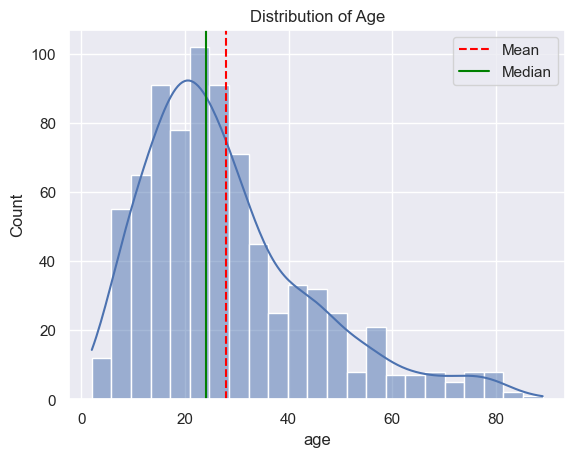

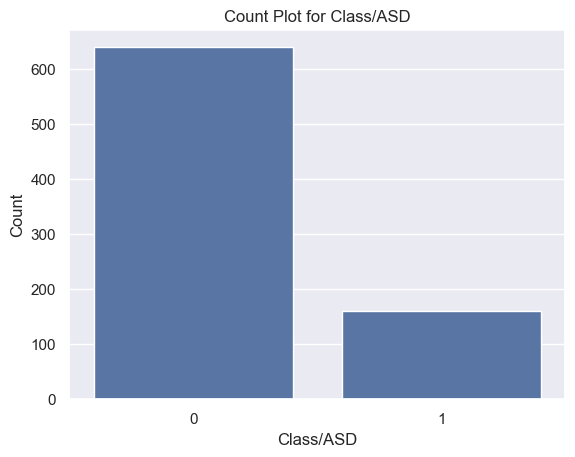

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


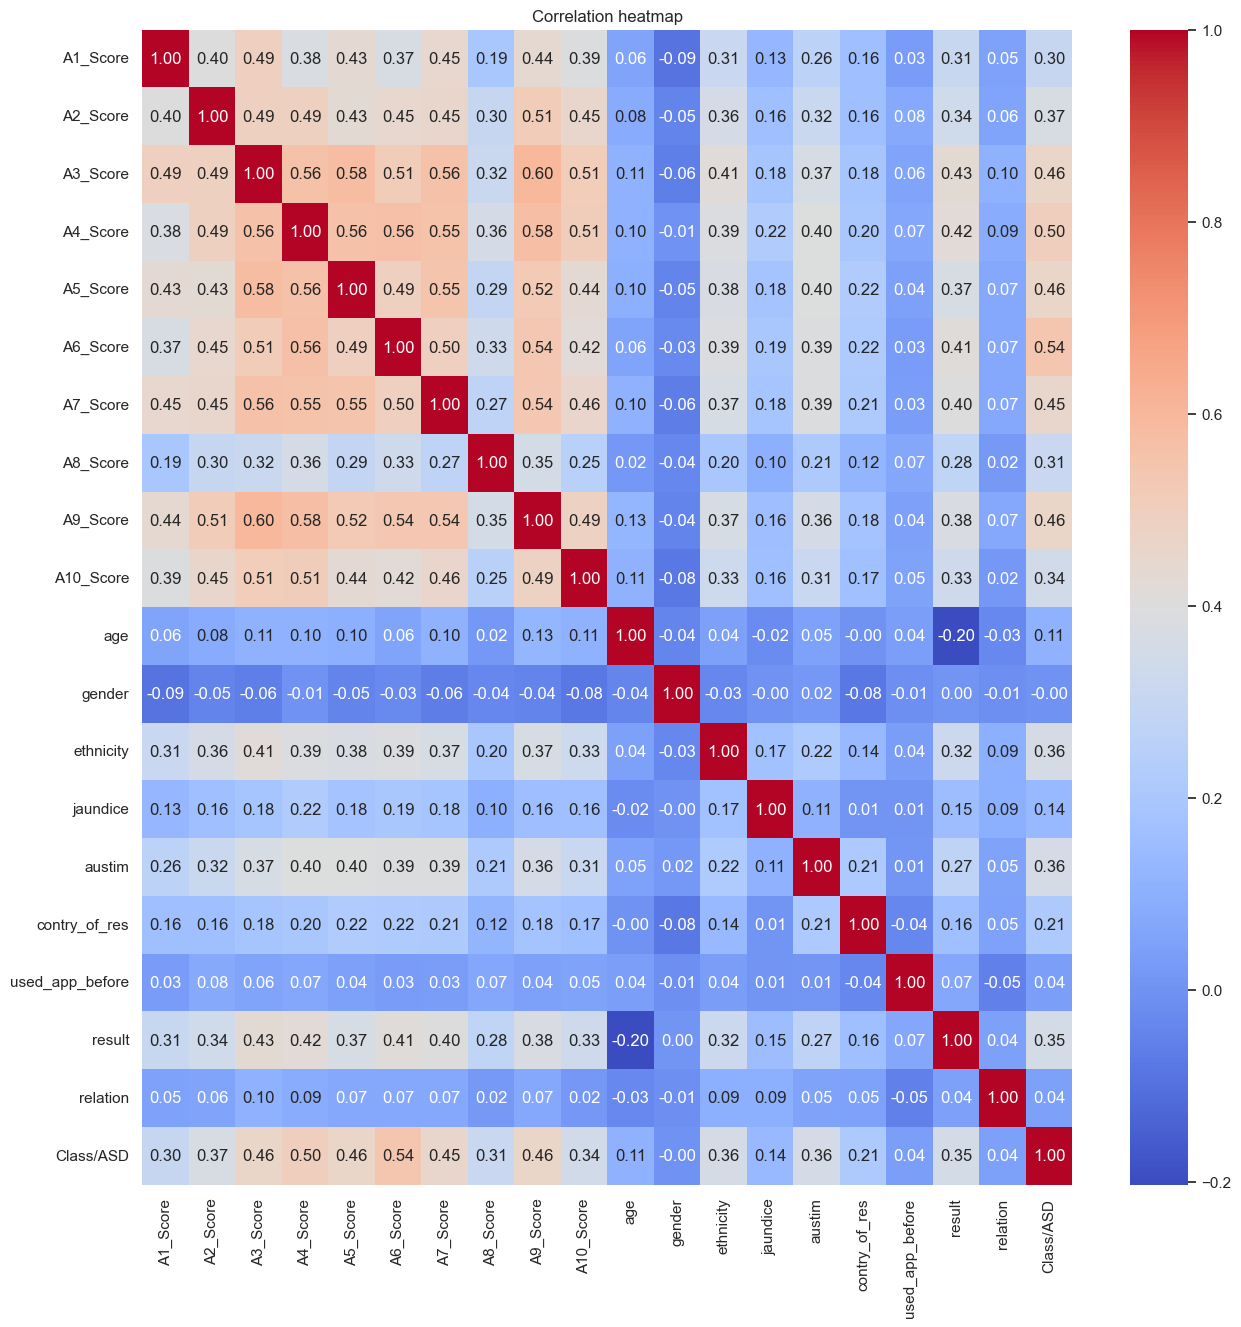

In [8]:
#*3. Exploratory Data Analysis (EDA)*
df.shape
df.columns
df.head(2)
df.describe()
sns.set_theme(style="darkgrid")
# Histogram for "age"
sns.histplot(df["age"], kde=True)
plt.title("Distribution of Age")
age_mean = df["age"].mean()
age_median = df["age"].median()
print("Mean:", age_mean)
print("Median:", age_median)
plt.axvline(age_mean, color="red", linestyle="--", label="Mean")
plt.axvline(age_median, color="green", linestyle="-", label="Median")
plt.legend()
plt.show()
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]
len(age_outliers)
Q1 = df["result"].quantile(0.25)
Q3 = df["result"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
result_outliers = df[(df["result"] < lower_bound) | (df["result"] > upper_bound)]
len(result_outliers)
# countplot for target column (Class/ASD)
sns.countplot(x=df["Class/ASD"])
plt.title("Count Plot for Class/ASD")
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.show()
df["Class/ASD"].value_counts()
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})
df["ethnicity"].unique()
df["relation"].unique()
df["relation"] = df["relation"].replace(
    {"?": "Others",
     "Relative": "Others",
     "Parent": "Others",
     "Health care professional": "Others"}
)
df["relation"].unique()
df.head()
# Label Encoding
object_columns = df.select_dtypes(include=["object"]).columns
print(object_columns)
encoders = {}
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder
# save the encoders as a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)
encoders
df.head()
# correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap")
plt.show()
#- There is a class imbalance in the target column

In [9]:
# Data preprocessing
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  median = df[column].median()
  df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
  return df
df = replace_outliers_with_median(df, "age")
df = replace_outliers_with_median(df, "result")
df.head()
df.shape
#*Train Test Split*
df.columns
X = df.drop(columns=["Class/ASD"])
y = df["Class/ASD"]
print(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.shape)
print(y_test.shape)
y_train.value_counts()
y_test.value_counts()

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         0         1         0         1         0         1   
1           0         0         0         0         0         0         0   
2           1         1         1         1         1         1         1   
3           0         0         0         0         0         0         0   
4           0         0         0         0         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
795         0         1         0         0         0         0         0   
796         0         1         1         0         0         1         0   
797         0         0         0         0         0         0         0   
798         0         0         0         0         0         0         0   
799         0         1         0         0         0         0         0   

     A8_Score  A9_Score  A10_Score   age  gender  ethnicity  jaundice  aust

Class/ASD
0    124
1     36
Name: count, dtype: int64

In [10]:
# SMOTE (Synthetic Minority Oversampling technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(y_train_smote.shape)
print(y_train_smote.value_counts())

(1030,)
Class/ASD
1    515
0    515
Name: count, dtype: int64


In [11]:
# Model Training
# Dictionary of classifiers with all 10 models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42, probability=True),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}
# metrics to evaluate
scoring_metrics = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "F1 Score": "f1"
}
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    scores_dict = {}
    
    for metric_name, scoring in scoring_metrics.items():
        scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring=scoring)
        mean_score = np.mean(scores)
        scores_dict[metric_name] = mean_score
        print(f"{model_name} Cross-Validation {metric_name}: {mean_score:.2f}")
    
    cv_scores[model_name] = scores_dict


Evaluating Decision Tree...
Decision Tree Cross-Validation Accuracy: 0.86
Decision Tree Cross-Validation Precision: 0.85
Decision Tree Cross-Validation Recall: 0.87
Decision Tree Cross-Validation F1 Score: 0.86

Evaluating Random Forest...
Random Forest Cross-Validation Accuracy: 0.92
Random Forest Cross-Validation Precision: 0.88
Random Forest Cross-Validation Recall: 0.98
Random Forest Cross-Validation F1 Score: 0.92

Evaluating XGBoost...
XGBoost Cross-Validation Accuracy: 0.90
XGBoost Cross-Validation Precision: 0.87
XGBoost Cross-Validation Recall: 0.96
XGBoost Cross-Validation F1 Score: 0.91

Evaluating KNN...
KNN Cross-Validation Accuracy: 0.86
KNN Cross-Validation Precision: 0.81
KNN Cross-Validation Recall: 0.95
KNN Cross-Validation F1 Score: 0.87

Evaluating SVM...
SVM Cross-Validation Accuracy: 0.82
SVM Cross-Validation Precision: 0.79
SVM Cross-Validation Recall: 0.88
SVM Cross-Validation F1 Score: 0.83

Evaluating Gradient Boosting...
Gradient Boosting Cross-Validation Ac

[0.8563106796116504, 0.9194174757281554, 0.903883495145631, 0.8592233009708737, 0.8203883495145631, 0.8941747572815535, 0.8368932038834951, 0.9097087378640778]


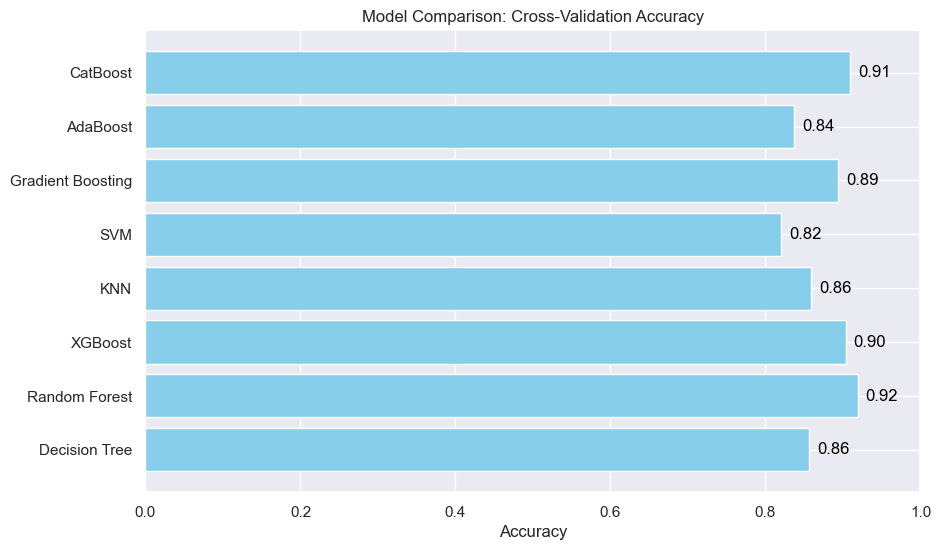

In [12]:
# Create a list of model names and their corresponding average accuracies
model_names = []
model_accuracy = []
for model_name, metrics in cv_scores.items():
    model_names.append(model_name)
    model_accuracy.append(metrics['Accuracy'])
print(model_accuracy)
# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, model_accuracy, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Comparison: Cross-Validation Accuracy')
plt.xlim(0, 1)
# Add accuracy values on the edges of each bar
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', color='black')
# Display the plot
plt.show()

In [13]:
# Load the trained RandomForest model and label encoders
with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
# Load the label encoders for categorical columns
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

def preprocess_input_data(input_data):
    input_df = pd.DataFrame([input_data])

    for column, encoder in encoders.items():
        try:
            seen_labels = set(encoder.classes_)
            input_df[column] = input_df[column].apply(lambda x: x if x in seen_labels else None)
            input_df[column] = encoder.transform(input_df[column].fillna(encoder.classes_[0]))  # Handle None by replacing with a default class
        except ValueError as e:
            print(f"Error processing column '{column}': {e}")
    input_df = input_df[X.columns]
    return input_df

input_data = {
    "age": 7,
    "result": 14.851484,
    "A1_Score": 1,
    "A2_Score": 1,
    "A3_Score": 1,
    "A4_Score": 1,
    "A5_Score": 1,
    "A6_Score": 1,
    "A7_Score": 1,
    "A8_Score": 1,
    "A9_Score": 1,
    "A10_Score": 1,
    "gender": 1,
    "ethnicity": 9,
    "jaundice": 0,
    "austim": 1,
    "contry_of_res": 52,
    "used_app_before": 0,
    "relation": 1
}

processed_data = preprocess_input_data(input_data)
prediction = rf_model.predict(processed_data)

if prediction == 1:
    print("Prediction: ASD detected (Class/ASD = 1)")
else:
    print("Prediction: No ASD detected (Class/ASD = 0)")

Prediction: ASD detected (Class/ASD = 1)
